In [ ]:
1. Input: User-Item interaction matrix R (where R[u][i] is the rating given by user u to item i)

2. Step 1: Preprocessing
   - Normalize user ratings (optional)

3. Step 2: Similarity Computation
   - For each user pair (u, v):
       - Calculate similarity between user u and user v using a similarity metric (e.g., Cosine similarity, Pearson correlation).

4. Step 3: Neighborhood Selection
   - For each user u:
       - Select the top-K most similar users (neighbors) based on the similarity scores.

5. Step 4: Rating Prediction
   - For each item i that user u has not rated:
       - Predict the rating R_pred[u][i] using the ratings of the top-K neighbors of user u.
       - R_pred[u][i] = Weighted sum of ratings from neighbors on item i.

6. Step 5: Recommendation Generation
   - For each user u:
       - Recommend the top-N items with the highest predicted ratings.

7. Output: Top-N item recommendations for each user

or
Importing the required PySpark library
Setup Spark Session
Load the CSV file
Display summary statistics
Splitting the data into training and test datasets (80% and 20% respectively)
Build the recommendation model using ALS on the training data
Fitting the model on the train_data
Evaluate the model by computing RMSE on the test data
Displaying predictions calculated by the model
Calculating RMSE
Filtering data for a specific user, e.g., user_id "5461"
Getting recommendations for the specified user
Convert Spark DataFrame to Pandas DataFrame for visualization
Convert the ratings data to Pandas DataFrame
Plot the distribution of ratings
Convert the predictions DataFrame to Pandas for analysis
Calculate the average actual and predicted ratings
Create a DataFrame to hold these values for plotting
Plotting the bar chart for average ratings    

# Collaborative_Filtering.csv

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows

+-------+-----------------+------------------+------------------+
|summary|          book_id|           user_id|            rating|
+-------+-----------------+------------------+------------------+
|  count|           981756|            981756|            981756|
|   mean|4943.275635697668|25616.759933221696|3.8565335989797873|
| stddev|2873.207414896143|15228.338825882149|0.9839408559619973|
|    min|                1|                 1|                 1|
|    max|            10000|             53424|                 5|
+-------+-----------------+------------------+------------------+

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|   1580|   1088|     5|   3.78319|
|   1591|  

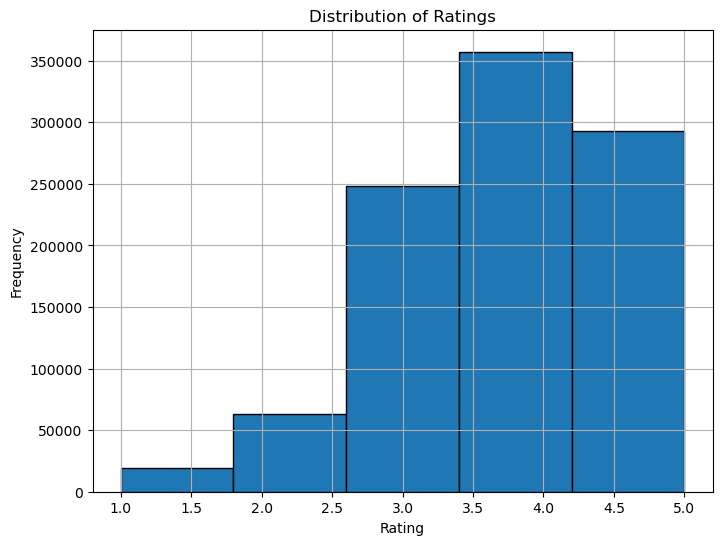

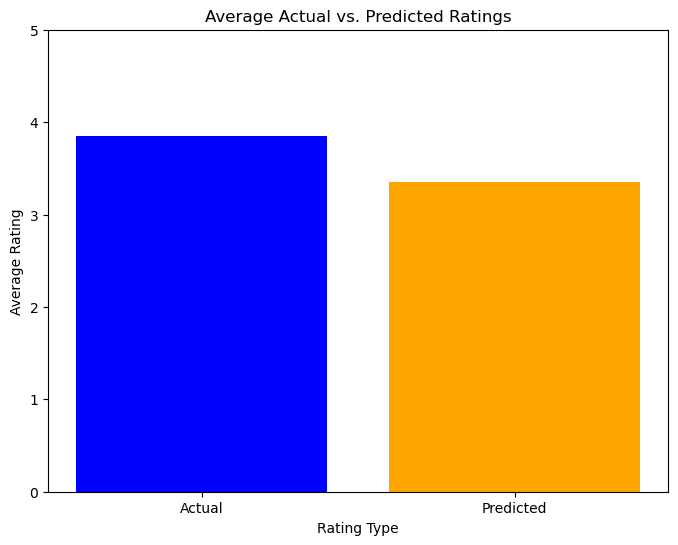

In [3]:
# %%
# Importing the required PySpark library
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Setup Spark Session
spark = SparkSession.builder.appName('Recommender').getOrCreate()

# %%
# Load the CSV file
data = spark.read.csv(r"Collaborative_Filtering.csv", inferSchema=True, header=True)
data.show(5)

# %%
# Display summary statistics
data.describe().show()

# %%
# Splitting the data into training and test datasets (80% and 20% respectively)
train_data, test_data = data.randomSplit([0.8, 0.2])

# %%
# Build the recommendation model using ALS on the training data
als = ALS(
    maxIter=5,
    regParam=0.01,
    coldStartStrategy="drop",
    userCol="user_id",
    itemCol="book_id",
    ratingCol="rating"
)
# Fitting the model on the train_data
model = als.fit(train_data)

# %%
# Evaluate the model by computing RMSE on the test data
predictions = model.transform(test_data)
# Displaying predictions calculated by the model
predictions.show()

# %%
# Calculating RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# %%
# Filtering data for a specific user, e.g., user_id "5461"
user_id = 5461
user_data = test_data.filter(test_data['user_id'] == user_id).select(['book_id', 'user_id'])
user_data.show()

# %%
# Getting recommendations for the specified user
recommendations = model.transform(user_data)
recommendations.orderBy('prediction', ascending=False).show()

# %%
# Convert Spark DataFrame to Pandas DataFrame for visualization
import matplotlib.pyplot as plt
import pandas as pd

# Convert the ratings data to Pandas DataFrame
ratings_pd = data.select("rating").toPandas()

# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings_pd['rating'], bins=5, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# %%
# Convert the predictions DataFrame to Pandas for analysis
predictions_pd = predictions.select("rating", "prediction").dropna().toPandas()

# Calculate the average actual and predicted ratings
average_actual_rating = predictions_pd['rating'].mean()
average_predicted_rating = predictions_pd['prediction'].mean()

# Create a DataFrame to hold these values for plotting
avg_ratings_df = pd.DataFrame({
    'Rating Type': ['Actual', 'Predicted'],
    'Average Rating': [average_actual_rating, average_predicted_rating]
})

# Plotting the bar chart for average ratings
plt.figure(figsize=(8, 6))
plt.bar(avg_ratings_df['Rating Type'], avg_ratings_df['Average Rating'], color=['blue', 'orange'])
plt.title('Average Actual vs. Predicted Ratings')
plt.xlabel('Rating Type')
plt.ylabel('Average Rating')
plt.ylim(0, 5)
plt.show()


In [4]:
recommended_movie_df = model.recommendForAllUsers(3)
recommended_movie_df.show(10, False)

+-------+---------------------------------------------------------+
|user_id|recommendations                                          |
+-------+---------------------------------------------------------+
|26     |[{9134, 4.704584}, {7412, 4.6904726}, {9798, 4.684291}]  |
|27     |[{9080, 10.970275}, {9458, 9.873446}, {5377, 9.57904}]   |
|28     |[{6142, 5.8380775}, {8812, 5.7094164}, {8902, 5.4520617}]|
|31     |[{8233, 5.595016}, {9553, 4.825694}, {7275, 4.717564}]   |
|34     |[{9418, 8.149466}, {9518, 6.936254}, {5986, 6.6584373}]  |
|44     |[{9460, 12.999341}, {8738, 10.420515}, {4484, 10.403021}]|
|53     |[{8946, 4.9938765}, {8259, 3.2754622}, {7412, 3.244303}] |
|65     |[{7412, 8.033155}, {7947, 7.939153}, {9458, 7.607985}]   |
|76     |[{7881, 11.421021}, {9080, 10.615054}, {9458, 9.536649}] |
|78     |[{9301, 3.0028985}, {5730, 2.9966388}, {9336, 2.9324358}]|
+-------+---------------------------------------------------------+
only showing top 10 rows



In [ ]:
spark.stop()

# songsDataset-Collaborative filtering.csv

In [1]:
# %%
# Importing the required PySpark library
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# Setup Spark Session
spark = SparkSession.builder.appName('Song_Recommender').getOrCreate()

# %%
# Load the CSV file
data = spark.read.csv(r"songsDataset-Collaborative filtering.csv", inferSchema=True, header=True)
data.show(5)

# %%
# Display summary statistics
data.describe().show()

# %%
# Splitting the data into training and test datasets (80% and 20% respectively)
train_data, test_data = data.randomSplit([0.8, 0.2])

# %%
# Build the recommendation model using ALS on the training data
als = ALS(
    maxIter=5,
    regParam=0.01,
    coldStartStrategy="drop",
    userCol="'userID'",
    itemCol="'songID'",
    ratingCol="'rating'"
)
# Fitting the model on the train_data
model = als.fit(train_data)

# %%
# Evaluate the model by computing RMSE on the test data
predictions = model.transform(test_data)
# Displaying predictions calculated by the model
predictions.show()

# %%

+--------+--------+--------+
|'userID'|'songID'|'rating'|
+--------+--------+--------+
|       0|    7171|       5|
|       0|    8637|       4|
|       0|   21966|       4|
|       0|   35821|       5|
|       0|   82446|       5|
+--------+--------+--------+
only showing top 5 rows

+-------+-----------------+------------------+------------------+
|summary|         'userID'|          'songID'|          'rating'|
+-------+-----------------+------------------+------------------+
|  count|          2000000|           2000000|           2000000|
|   mean|          99999.5|     67989.3130595|          3.459467|
| stddev|57735.04135200295|39404.550267508755|1.5537185340117672|
|    min|                0|                 0|                 1|
|    max|           199999|            136735|                 5|
+-------+-----------------+------------------+------------------+

+--------+--------+--------+-----------+
|'userID'|'songID'|'rating'| prediction|
+--------+--------+--------+---------

Root-mean-square error = 6.907910081425937
+--------+--------+
|'songID'|'userID'|
+--------+--------+
|  104400|    5461|
|  134265|    5461|
+--------+--------+

+--------+--------+----------+
|'songID'|'userID'|prediction|
+--------+--------+----------+
|  134265|    5461|-2.5969617|
|  104400|    5461|-10.593687|
+--------+--------+----------+



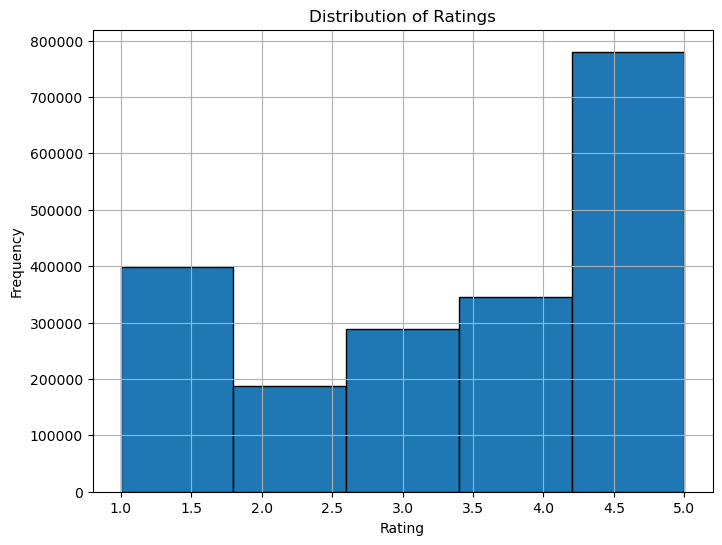

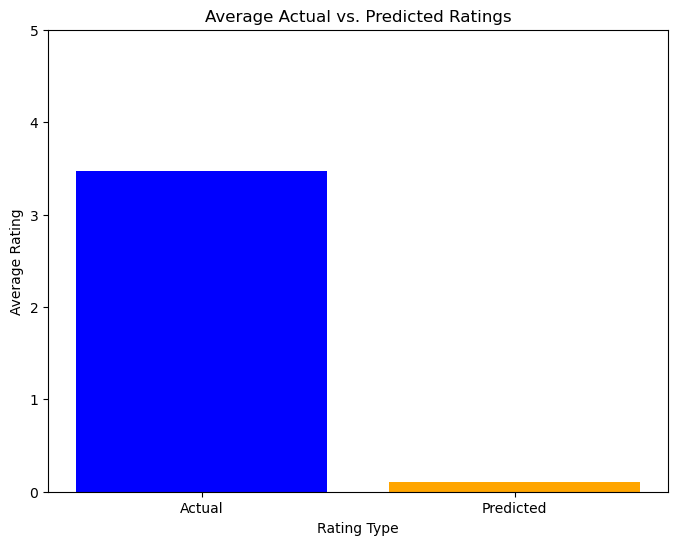

In [2]:
# Calculating RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="'rating'", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# %%
# Filtering data for a specific user, e.g., user_id "5461"
user_id = 5461
user_data = test_data.filter(test_data["'userID'"] == user_id).select(["'songID'", "'userID'"])
user_data.show()

# %%
# Getting recommendations for the specified user
recommendations = model.transform(user_data)
recommendations.orderBy('prediction', ascending=False).show()

# %%
# Convert Spark DataFrame to Pandas DataFrame for visualization
import matplotlib.pyplot as plt
import pandas as pd

# Convert the ratings data to Pandas DataFrame
ratings_pd = data.select("'rating'").toPandas()

# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings_pd["'rating'"], bins=5, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# %%
# Convert the predictions DataFrame to Pandas for analysis
predictions_pd = predictions.select("'rating'", "prediction").dropna().toPandas()

# Calculate the average actual and predicted ratings
average_actual_rating = predictions_pd["'rating'"].mean()
average_predicted_rating = predictions_pd['prediction'].mean()

# Create a DataFrame to hold these values for plotting
avg_ratings_df = pd.DataFrame({
    'Rating Type': ['Actual', 'Predicted'],
    'Average Rating': [average_actual_rating, average_predicted_rating]
})

# Plotting the bar chart for average ratings
plt.figure(figsize=(8, 6))
plt.bar(avg_ratings_df['Rating Type'], avg_ratings_df['Average Rating'], color=['blue', 'orange'])
plt.title('Average Actual vs. Predicted Ratings')
plt.xlabel('Rating Type')
plt.ylabel('Average Rating')
plt.ylim(0, 5)
plt.show()

In [3]:
recommended_movie_df = model.recommendForAllUsers(3)
recommended_movie_df.show(10, False)

+--------+-------------------------------------------------------------+
|'userID'|recommendations                                              |
+--------+-------------------------------------------------------------+
|26      |[{80497, 10.559761}, {95905, 10.512878}, {35184, 10.075956}] |
|27      |[{127726, 15.165144}, {31277, 13.453441}, {89134, 13.373798}]|
|28      |[{36904, 10.379817}, {23954, 10.292014}, {113170, 9.709205}] |
|31      |[{88956, 71.19593}, {39161, 69.96026}, {1495, 68.932915}]    |
|34      |[{123816, 21.732204}, {20976, 20.744925}, {45535, 20.203259}]|
|44      |[{117191, 41.36347}, {25353, 40.53605}, {101793, 39.071495}] |
|53      |[{13035, 13.909906}, {100095, 13.880409}, {6962, 13.802198}] |
|65      |[{51648, 32.607956}, {51382, 30.336267}, {51721, 29.7401}]   |
|76      |[{77296, 23.85017}, {111206, 23.48242}, {44172, 23.006979}]  |
|78      |[{44745, 12.079518}, {47604, 11.497964}, {5611, 11.404559}]  |
+--------+-----------------------------------------